NETWORK DESING, TRAINING AND TESTING 


In [1]:
import keras
from keras import layers
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pylab as plt
import os
import shutil

In [2]:
posCls = 'faces'
negCls = 'backgrounds'
root_dir = str(os.getcwd()) 
data_splitting = False
if data_splitting:
    os.makedirs(root_dir +'/train_data_' + posCls)
    os.makedirs(root_dir +'/train_data_' + negCls)
    os.makedirs(root_dir +'/val_data_' + posCls)
    os.makedirs(root_dir +'/val_data_' + negCls)

    # Creating partitions of the data after shuffeling
    currentCls = posCls, negCls

    for i in range(len(currentCls)):
        src = root_dir + '/' + currentCls[i] # Folder to copy images from


        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*0.9)])    

        train_FileNames = [src + "\\"  + name for name in train_FileNames.tolist()]
        val_FileNames = [src+ '\\' + name for name in val_FileNames.tolist()]

    #    print('Total images: ', len(allFileNames))
    #    print('Training: ', len(train_FileNames))
    #    print('Validation: ', len(val_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + "/train_data_"+currentCls[i])

        for name in val_FileNames:
            shutil.copy(name, root_dir + "/val_data_"+currentCls[i])


    #then create val_data folder and test_data folder and put the right folder inside


In [3]:
batch_size = 128
img_window = (32,24,1)
input_shape = np.prod(img_window)

#network
def create_model(dropout_rate, neuron_1, neuron_2, neuron_3,neuron_4, activation_function):
    optimizer = 'Adam'
    model = keras.Sequential(
        [            
            layers.InputLayer(input_shape=img_window),
            layers.Flatten(),
            layers.Dense(neuron_1, activation=activation_function),
            layers.Dropout(dropout_rate),
            layers.Dense(neuron_2, activation=activation_function),
            layers.Dropout(dropout_rate),
            layers.Dense(neuron_3, activation=activation_function),
            layers.Dropout(dropout_rate),
            layers.Dense(neuron_4, activation=activation_function),
            layers.Dense(2, activation="softmax")
        ]
    ) 
        
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) #
    return model


In [6]:
gridSearch = True
if gridSearch:
    from sklearn.model_selection import GridSearchCV
    from keras.wrappers.scikit_learn import KerasClassifier
    # create model
    model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=100, verbose=0)
    
    #optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    activation_fn = ['relu', 'tanh']
    dropout_rate = [0.1,0.2]
    neuron_1 = [256, 128]
    neuron_2 = [128, 64]
    neuron_3 = [32, 16]
    
    #optimizer, activation_function, dropout_rate, neuron_1, neuron_2, neuron_3
    
    param_grid = dict(dropout_rate=dropout_rate, neuron_1=neuron_1, neuron_2=neuron_2, neuron_3=neuron_3, activation_function=activation_fn)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,cv = 3)
    validation_generator_GS = valid_datagen.flow_from_directory(
            'val_data',
            target_size=img_window[:2],
            batch_size=828, # 828 so we can use grid.fit on all the validation dataset (1 batch)
            class_mode='categorical',
            color_mode='grayscale')
    X_val, Y_val = validation_generator_GS.next()
    
    grid_result = grid.fit(X_val, Y_val)
  
    # result
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Found 828 images belonging to 2 classes.


Best: 0.751208 using {'activation_function': 'relu', 'dropout_rate': 0.1, 'neuron_1': 128, 'neuron_2': 128, 'neuron_3': 16}


The GridSearch procedure run in google Colab produce the output: <br> Best: 0.780193 using {'activation_function': 'relu', 'dropout_rate': 0.1, 'neuron_1': 256, 'neuron_2': 128, 'neuron_3': 32}

In [5]:
from keras.preprocessing.image import ImageDataGenerator

#Data_augmentation 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range= 0.2,
        zoom_range=0.2,
        horizontal_flip=True)
valid_datagen= ImageDataGenerator(
        rescale=1./255,
        shear_range= 0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'train_data',
        target_size=img_window[:2],
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')
        
validation_generator = valid_datagen.flow_from_directory(
        'val_data',
        target_size=img_window[:2],
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

Found 7444 images belonging to 2 classes.
Found 828 images belonging to 2 classes.


In [12]:
model_tuned = create_model(0.1, 256, 128, 64,32, 'relu')
history = model_tuned.fit_generator(
        train_generator,
        steps_per_epoch = 58,
        epochs = 50,
        validation_data=validation_generator,
        validation_steps=5
        )

Epoch 1/50
58/58 [==============================] - 6s 99ms/step - loss: 0.5278 - accuracy: 0.7463 - val_loss: 0.3869 - val_accuracy: 0.8422
Epoch 2/50
58/58 [==============================] - 6s 109ms/step - loss: 0.4450 - accuracy: 0.7910 - val_loss: 0.3753 - val_accuracy: 0.8266
Epoch 3/50
58/58 [==============================] - 7s 114ms/step - loss: 0.3903 - accuracy: 0.8302 - val_loss: 0.3640 - val_accuracy: 0.8359
Epoch 4/50
58/58 [==============================] - 7s 123ms/step - loss: 0.3659 - accuracy: 0.8424 - val_loss: 0.3430 - val_accuracy: 0.8547
Epoch 5/50
58/58 [==============================] - 6s 105ms/step - loss: 0.3554 - accuracy: 0.8476 - val_loss: 0.3523 - val_accuracy: 0.8359
Epoch 6/50
58/58 [==============================] - 7s 125ms/step - loss: 0.3432 - accuracy: 0.8510 - val_loss: 0.3690 - val_accuracy: 0.8359
Epoch 7/50
58/58 [==============================] - 6s 112ms/step - loss: 0.3334 - accuracy: 0.8554 - val_loss: 0.2962 - val_accuracy: 0.8766
Epoch 8

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


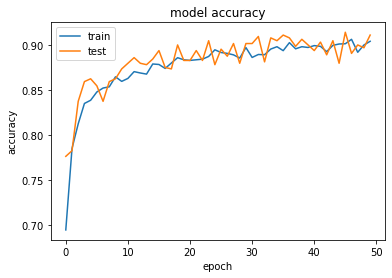

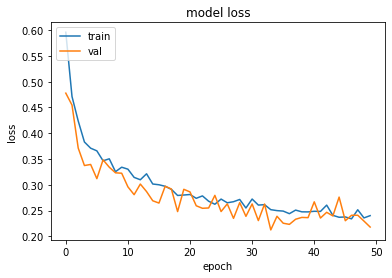

In [8]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [9]:
test_datagen= ImageDataGenerator(rescale=1./255)
        
test_generator = test_datagen.flow_from_directory(
        'test_data',
        target_size=img_window[:2],
        batch_size=2070,
        class_mode='categorical',
        color_mode='grayscale',
        shuffle=False)
filenames = test_generator.filenames
nb_samples = len(filenames)
# %%
#ACCURACY
filenames = test_generator.filenames
nb_samples = len(filenames)
y_pred = model_tuned.predict_generator(generator=test_generator, steps = 1) # , steps=np.ceil(nb_samples/batch_size)
y_pred = np.argmax(y_pred, axis=1)
y_test = test_generator.classes


Found 2070 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


In [11]:
#MEASURE
from sklearn.metrics import precision_score, accuracy_score,f1_score, recall_score, roc_auc_score
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)
# F1 = 2 * (precision * recall) / (precision + recall)
F1= roc_auc_score(y_test,y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('ROC:', ROC)
print("F1",F1)

Accuracy: 0.8985507246376812
Precision: 0.8932316491897044
Recall: 0.9053140096618357
ROC: 0.8985507246376812
F1 0.8985507246376812
